In [1]:
import pandas as pd #module to work with dataframes
import networkx as nx #module to work with networks
import numpy as np
import matplotlib.pyplot as plt
import random
from networkx.algorithms import bipartite #we load the bipartite algorithms to facilitate writing the code

from Functions import *

# Dynamics ON networks

## Generalized Lotka-Volterra (steady state)

It is easy to obtain the steady state of a generalized Lotka-Volterra, as it is only solving a system of equations! 

Let's see how we can do it using as an example the mutualistic network of pollination from Argentina.

In [2]:
filename="./data/pollination/Medan_Rio_Blanco.csv"
#1. Read the file and sotre in dataframe
Idf=pd.read_csv(filename, header=0, index_col=0)
#print(Idf.head())

#2. Create bipartite network
# Initialize an empty bipartite graph
B = nx.Graph()
# Add producers (rows) and consumers (columns) as nodes
plants = Idf.index
animals = Idf.columns

# Add nodes with a bipartite identifier
B.add_nodes_from(plants, bipartite="plant")  # Set for producers
B.add_nodes_from(animals, bipartite="animal")  # Set for consumers
# Add edges for non-zero interactions, we can also use the matrix directly
for plant in plants:
    for animal in animals:
        if Idf.loc[plant, animal] != 0:
            B.add_edge(plant, animal)
            

In [3]:
#convert to incidence matrix to build from there the matrix of the model
Imat=nx.to_pandas_adjacency(B).loc[animals, plants]
#create the matrix of the model
matrices=interaction_matrix(Imat)
A=matrices["alpha"]#this is the matrix of itneractions among all species, we use that with all species (A)
r=simplex_sampling(1,len(A)) #sample reproductive rates randomly in the unit sphere
N_sol = np.linalg.inv(A) @ r[0].reshape(-1, 1) #solve the system of equations
N_sol[0:5]

array([[0.01138226],
       [0.01442421],
       [0.00833527],
       [0.00794417],
       [0.00688267]])

In gneral, we will be interested in knowing for example how frequantly a given species is present in the community, or on the \% of surviving species as a function of the itneraction entwork, so we will to solve the system many times

In [4]:
#model dynamical parameters
N_sim=500
rho=0.005
delta=0.0
gamma_avg=0.1

Surv_df=pd.DataFrame(index=np.arange(N_sim),  columns=list(A)) #to store results

#create the model matrices
Imat=nx.to_pandas_adjacency(B).loc[animals, plants]
matrices=interaction_matrix(Imat,gamma_avg = gamma_avg, rho = rho, delta = delta)
A=matrices["alpha"]#this is the matrix of itneractions among all species
r=simplex_sampling(N_sim,len(A)) #we sample the rs beforehand

#run the simulation N_sim times
for sim in range(N_sim):
    ri=r[sim]
    N_sol = np.linalg.inv(A) @ r[sim].reshape(-1, 1) #solve the system of equations
    psurvivors=[0 if i<0 else 1 for i in N_sol] #we want to know if the species is present
    Surv_df.iloc[sim]=psurvivors

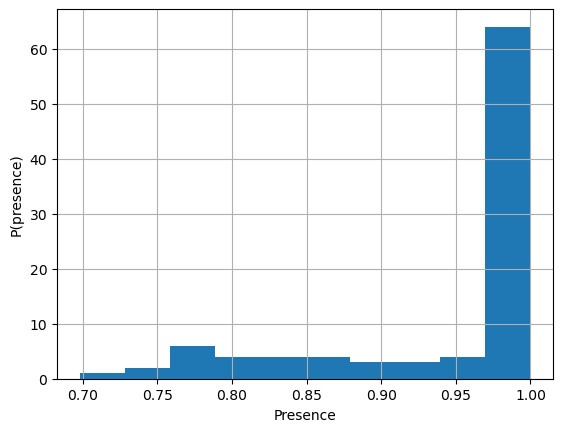

In [5]:
((Surv_df.sum()/N_sim)).hist() #histogram of the number of species that is present from 0 to 1 of the simulations
plt.xlabel("Presence")
plt.ylabel("P(presence)")
plt.show()

In [6]:
np.mean(Surv_df.sum(axis=1)/len(A)) #average persistence across simulations (%of species present)

0.9444421052631583

<div class="alert alert-block alert-success"><b>Up to you: </b>
<h4> Exercise 26</h4>
    
Create a randomized version of the network using the gnmk model (keeping constant $Np$,$Na$ and $L$$) and run the simulation on it. 
    
- 1. Do you think there will be a difference in species persistence?
- 2. Run the simulation and plot the histogram of persistence of the random community togheter with the original community. What do you see?
    
    
</div>


In [ ]:
## your code here
# 1. create the randomized version of the bipartite networks as in lesson3A
# 2. repeat the simulation procedure using the randomized matrix. 
# 3. store the results in a new dataframe, similarly as above
# 4. plot the two histogrmas of presence togheter, una after the other.

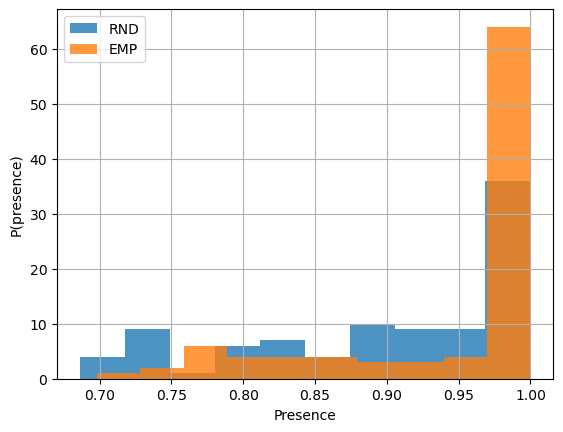

In [ ]:
# %load ./snippets/ex26.py
# 4. Generate the random version of the network
Nplants=len(plants)
Nanimals=len(animals)
L=B.number_of_edges()

B_R1=bipartite.gnmk_random_graph(Nplants, Nanimals , L)
# to force that the graph uses bipartite="plant" or bipartite="animal" instead of the o and 1 by default we can do:
for n in range(Nplants):
    B_R1.nodes[n]["bipartite"]="plant"
for n in range(Nplants,Nplants+Nanimals):
    B_R1.nodes[n]["bipartite"]="animal"

#Create mappings for renaming
plant_mapping = {i: plants[i] for i in range(Nplants)}
pollinator_mapping = {i + Nplants: animals[i] for i in range(Nanimals)}

# Combine the mappings
mapping = {**plant_mapping, **pollinator_mapping}

# Relabel the nodes in the bipartite graph
B_R1 = nx.relabel_nodes(B_R1, mapping)

################
SurvR1_df=pd.DataFrame(index=np.arange(N_sim),  columns=list(A)) #create dataframe to store results

rho=0.005 
delta=0.0
gamma_avg=0.1

ImatR1=nx.to_pandas_adjacency(B_R1).loc[animals, plants]
matricesR1=interaction_matrix(ImatR1, gamma_avg = gamma_avg, rho = rho, delta = delta)
AR1=matricesR1["alpha"]#this is the matrix of itneractions among all species
#r=simplex_sampling(1,len(A)) #sample reproductive rates randomly in the unit sphere, we reuse the same as before!

#run the simulation
for sim in range(N_sim):
    ri=r[sim]
    N_sol = np.linalg.inv(AR1) @ r[sim].reshape(-1, 1) #solve the system of equations
    psurvivors=[0 if i<0 else 1 for i in N_sol]
    SurvR1_df.iloc[sim]=psurvivors
    
#######
((SurvR1_df.sum()/N_sim)).hist(alpha=0.8,label="RND")
((Surv_df.sum()/N_sim)).hist(alpha=0.8, label="EMP")
plt.xlabel("Presence")
plt.ylabel("P(presence)")
plt.legend()
plt.show()

In [ ]:
O, OP_eff, OA_eff= calc_Omegas_py(Imat)
O

0.5348528765505612

## Simulating processes
Now we will see how to use the included Simulation class to simulate node dynamics by specifying a graph, the initial state of the nodes, and node state transitions.

## The Simulation class

Included in the folder is a `simulation.py` file that contains a `Simulation` class. This class will allow us to skip the details of writing a simulation, allowing us to concentrate on the interesting parts.

## Creating a simulation

A simulation is made up of three main parts:

1. The graph on which to simulate node dynamics
2. The initial state of each node
3. The state transition function

Lets see it with an example of a very simple dynamic

## 1. Sleep-Awake

## 1.1 Create the simulation

### 1.1.1 The graph

This one is easy, we just need a NetworkX Graph instance. For this example we'll use a random graph. You can run the following cell multiple times if you wish, until you get a graph that looks good:

In [ ]:
G = nx.gnm_random_graph(20, 50)
nx.draw(G)

### 1.1.2 The initial state

In these simulations, state is represented as a dictionary where the keys are node names and the values are the state of the node. We can specify the initial state either directly as one of these dictionaries, or we can specify a function that generates such a state dictionary.

The function version is cleaner; let's use it to generate a very simple initial state where every node has the same state: 'asleep'.

In [ ]:
# An initial_state function takes one argument, the graph instance.

def initial_state(G):
    state = {}
    for node in G.nodes:
        state[node] = 'asleep'
    return state

In [ ]:
initial_state(G)

This looks good.

### 1.1.3. The state transition function

The crux of the simulation is the state transition function: this is where we specify the *dynamics*. This function takes two arguments, the graph and the current node states provided as a dictionary, and should return a dictionary of the updated states.

In this simple example, at each simulation step, each node with the `'asleep'` state will have a fixed probability to transition to the `'awake'` state. We'll specify this probability as `P_AWAKEN`, the probability an asleep node will awaken at each step.

Generically, in order to do a thing with some probability, we generate a random number between 0 and 1 with the `random.random()` function and compare to our probability threshold: if the random number is below our probability threshold, then we do the thing.

In [ ]:
P_AWAKEN = 0.2
def state_transition(G, current_state):
    next_state = {}
    for node in G.nodes:
        if current_state[node] == 'asleep':
            if random.random() < P_AWAKEN:
                next_state[node] = 'awake'
    return next_state

Note that this function only has to provide the states that *change* during this step, although no harm would be done by specifying the state for every node, changed or not.

We can do a dry run if we want, just to make sure our transition function works:

In [ ]:
test_state = initial_state(G)
state_transition(G, test_state)

We should see some nodes transition to the `'awake'` state in this test run, which is good.

### 1.1.4 Putting together the pieces

We now have our three pieces: the graph, the initial state, and the state transition function. Let's put them together along with a name for our simulation to create a Simulation object:

In [ ]:
from simulation import Simulation

sim = Simulation(G, initial_state, state_transition, name='Simple Sim')

The `name` provided here is optional, it just for us to keep track of the images we'll generate later.

This Simulation object has several useful methods. The first of these is the `.state()` method, which returns a dictionary for the current state of the simulation:

In [ ]:
sim.state()

We haven't done any steps in the simulation yet, so the state should be exactly our initial condition.

We can also draw the network with its nodes colored by their state values with the `.draw()` method:

In [ ]:
sim.draw()

Our initial condition has all nodes `'asleep'`, so this checks out.

## 1.2 Running the simulation

With our initial condition checked out, let's run the simulation! The simulation will advance in discrete *steps*: each step is one run of the state transition function.

The `.run()` method without any arguments will run the simulation one step:

In [ ]:
sim.run()

We can confirm the simulation advanced a step by checking out the `.steps` property, which tells us how many times the state transition function has been run:

In [ ]:
sim.steps

In [ ]:
sim.draw(with_labels=True)

In [ ]:
sim.state()

If we give the `.run()` method a number, we can run the simulation several steps at once:

In [ ]:
sim.run(10)

In [ ]:
sim.steps

The `.steps` method confirms that our simulation went through several simulation steps. Let's check up on the current state:

In [ ]:
sim.draw(with_labels=True)

## 1.3 Visualizing the results

By this point, all or most of the nodes should be awake, but how did that transition occur? Was it gradual or all at once? With the `.plot()` method, we can plot the proportion of nodes in each state at each step of the simulation:

In [ ]:
sim.plot()

If we want to visualize the state of the graph at a specific step, we can specify the desired step in the `.draw()` function.

In [ ]:
sim.draw(4, with_labels=True)

The same is true for the `.state()` method:

In [ ]:
sim.state(4)

If we only want to plot a subset of the steps, we can do that too by passing the min and/or max steps we want to plot. Do note that the bounds passed to the `.plot()` method are half-open, like Python's `range()` function and list slices, so that `.plot(2, 8)` plots states from 2 and up to but *not* including 8.

In [ ]:
sim.plot(min_step=2, max_step=8)

## 2. Voter model


In our trivial awake/asleep model above we ignored the underlying graph structure and each node's dynamics was independent of its neighbors. In interesting network models, we make use of the graph connectivity in some way.

The voter model is a simple model of network opinion dynamics capable of producing interesting output. W're going to implement it here.

## 2.1 Create the simulation

### 2.1.1 The Graph

We're going to use another random graph here, same as before.

In [ ]:
G = nx.gnm_random_graph(20, 50)
nx.draw(G)

### 2.1.2 Initial state

For the initial state, we will randomly assign each node a state by randomly selecting a letter A to D -- we're not limited to two states here!

We'll make use of `random.choice()` in both the initial state and state transition functions. This function is used to randomly choose one item from a given collection.

In [ ]:
import random
import string

def initial_state(G):
    state = {}
    for node in G.nodes:
        state[node] = random.choice('ABCD')
    return state

Let's make sure this works:

In [ ]:
initial_state(G)

### 2.1.3 State transition

The algorithm at the heart of the voter model works like this: for each node in the graph, choose a neighbor at random and copy their "opinion", *i.e.* set this node's state to the same value as that of the neighbor.

* For each node in the graph
  * Choose a neighbor at random
  * Set this node state equal to the neighbor state 

In [ ]:
def state_transition(G, current_state):
    next_state = {}
    for node in G.nodes:
        # Caveat: what if the node has no neighbors?
        if G.degree(node) > 0:
            neighbor = random.choice(list(G.neighbors(node)))
            next_state[node] = current_state[neighbor]
    return next_state

Let's test this out before moving forward:

In [ ]:
test_state = initial_state(G)
state_transition(G, test_state)

###  2.1.4 The Simulation instance

Looks good. Now let's create the simulation and visualize the initial state:

In [ ]:
sim = Simulation(G, initial_state, state_transition, name='Voter Model')

In [ ]:
sim.draw()

# if you care about the order of the labels in the legend,
# you can specify labels='ABCD' as a keyword argument for .draw()

## 2.2 Run the simulation

Let's run this simulation several steps and see where we end up:

In [ ]:
sim.run(40)

In [ ]:
sim.draw()

## 2.3 Visualize the results

It's probably different from where we started; let's see how we got here:

In [ ]:
sim.plot()

Go ahead and execute the previous few cells again, running the simulation forward and examining the state, until it reaches the long-term steady state: all of the nodes should eventually end up with the same state.

## 2.4 Synchronous vs. asynchronous updates

As written, this `state_transition` function performs a **synchronous** update, *i.e.* all of the nodes' states are updated at the same time, after the function returns the new state:

In [ ]:
# This is the same as in 2.1.3
import random

def state_transition(G, current_state):
    next_state = {}
    for node in G.nodes:
        if G.degree(node) > 0:
            neighbor = random.choice(list(G.neighbors(node)))
            next_state[node] = current_state[neighbor]
    return next_state

Note how this function never changes the values of `current_state` so that each node's update is based on the same information. Since each node "sees" the same state, the order in which we update the nodes doesn't matter. This is equivalent to updating all of the node states simultaneously. 

One can instead perform an **asynchronous** update, where each node sees the state changes that have taken place this step, by making in-place changes to `current_state`:

In [ ]:
# This example is potentially biased, don't use it
def state_transition_async(G, current_state):
    for node in G.nodes:
        if G.degree(node) > 0:
            neighbor = random.choice(list(G.neighbors(node)))
            current_state[node] = current_state[neighbor]
    return current_state

In this example, each node's view of `current_state` reflects the changes made in this step by previous node updates.

There is a potential problem here, however: `G.nodes` is likely to always return the nodes in the same order, thus performing the updates in the same order and potentially introducing bias. We should instead loop over the nodes in a random order each time:

In [ ]:
def state_transition_async(G, current_state):
    # Randomizing the update order prevents bias
    nodes_to_update = list(G.nodes)
    random.shuffle(nodes_to_update)
    for node in nodes_to_update:
        if G.degree(node) > 0:
            neighbor = random.choice(list(G.neighbors(node)))
            current_state[node] = current_state[neighbor]
    return current_state

We can make use of this new state transition function by passing it to the `Simulation` class, then run it and compare to the synchronous version above.

In [ ]:
sim = Simulation(G, initial_state, state_transition_async, name='Async Voter Model')
sim.run(40)
sim.plot()

Asynchronous updates may or may not produce a different result depending on the particular dynamics of your simulation. Synchronous updates are slightly simpler in terms of their assumptions which is an advantage, but certain update mechanisms can fail to converge to the steady state without asynchronous updates.

## 2.5 Stop condition

In some situations we may want to specify a condition which, when true, causes the simulation to end early. In this Voter model example, we observe that the system state can't change once all of the nodes have the same state. In order to avoid running the simulation longer than necessary, we can specify a stop condition to stop the simulation if all nodes have the same state.

This function takes the graph and current state as arguments, same as the state transition function, and returns `True` if the model should stop.

In [ ]:
def stop_condition(G, current_state):
    unique_state_values = set(current_state.values())
    is_stopped = len(unique_state_values) <= 1
    return is_stopped

Let's create another instance of the voter model, specifying a stop condition, and run it for more steps than we think we'll need. We still need to specify a maximum number of steps in case there is a bug in our stop condition and it never returns True.

In [ ]:
sim = Simulation(G, initial_state, state_transition, stop_condition, name='Voter model')
sim.run(100)

In [ ]:
sim.steps

In [ ]:
sim.plot()

## 2.6 Rewiring the graph

Since we have access to the Graph instance in our transition function, we can add or remove links in the graph if our system calls for it. Let's add an extension to the voter model such that a node may also "unfriend" another node by removing the edge between them if their state differs.

In [ ]:
def state_transition_async_rewiring(G, current_state):
    # Randomizing the update order prevents bias
    nodes_to_update = list(G.nodes)
    random.shuffle(nodes_to_update)
    for node in nodes_to_update:
        if G.degree(node) > 0:
            # This is the same as before
            neighbor = random.choice(list(G.neighbors(node)))
            current_state[node] = current_state[neighbor]
            # This is the new part
            neighbor = random.choice(list(G.neighbors(node)))
            if current_state[node] != current_state[neighbor]:
                G.remove_edge(node, neighbor)
            
    return current_state

In [ ]:
sim = Simulation(G, initial_state, state_transition_async_rewiring, stop_condition,
                 name='Voter Model with rewiring')
sim.draw()

In [ ]:
sim.run(40)
sim.draw()

In [ ]:
sim.plot()

The long-term behavior of this modified simulation is different than the previous model: it often ends up in a configuration with disconnected components, each containg nodes all of the same state. As such, the stop conditon as written doesn't trigger. Creating a proper `stop_condition` function for this state transition function is left as an exercise to the reader.

<div class="alert alert-block alert-success"><b>Up to you: </b>
<h3> Exercise 27</h3>
    
Create different networks and explore how network topolgy affects consensus time.
    
 -1. Lattice model
    
 -2. Small world Network
    
 -3. Scale-free network
    
 -4. Stochastic Block model
    
 - Which one do you expect to have a longer consensus time? and the shorter?
    
</div>

In [ ]:
# Common parameters for the graphs
N=100
k=4
L=k*N
p=0.1
m=L//(N-1)
# Set size of each community
community_sizes = [25, 25, 25,25]
community_probs =  np.array([[0.5, 0.01, 0.02,0.0], 
                   [0.01, 0.6, 0.05,0.0], 
                   [0.02, 0.05, 0.5,0.05],
                   [0.0 , 0.0 , 0.05, 0.5]])

In [ ]:
# SOLUTION: uncomment line below to load solution
# %load ./snippets/ex27-1.py

<div class="alert alert-block alert-success"><b>Up to you: </b>
<h3> Exercise 28</h3>
    
Now run the simulation in the SBM netowrk, but initialize with a polarized state, where the nodes in each group have the same opinion.
    
- Does it take longer to reach consesus?
    
</div>

In [ ]:
## code here

In [ ]:
# SOLUTION: uncomment line below to load solution
# %load ./snippets/ex28a.py


In [ ]:
# SOLUTION: uncomment line below to load solution
# %load ./snippets/ex28b.py


## 3. SIS and SIR model

This is one of the fundamental models of spreading dynamics on networks, examined in detail in the text. We will implement this spreading model using our simulation framework.

## 3.1 Create the Simulation

### 3.1.1 The Graph

In [ ]:
G = nx.gnm_random_graph(20, 50)
nx.draw(G)

### 3.1.2 Initial state

We will initially assign every node to the 'S' state and then randomly choose one node to infect by setting it to the 'I' state. You should experiment with different choices of the "patient zero" node to infect and see how it affects the spreading dynamics, *e.g.* by selecting a high- or low-degree node.

In [ ]:
import random

def initial_state(G):
    state = {}
    for node in G.nodes:
        state[node] = 'S'
    
    patient_zero = random.choice(list(G.nodes))
    state[patient_zero] = 'I'
    return state

Let's make sure this works:

In [ ]:
initial_state(G)

### 3.1.3 State transition

The SIS model involves two parameters, $\beta$ is the probability to transition from S to I given an infected neighbor, and $\mu$, the probability of transitioning from I to S.

In pseudocode, the algorithm looks like this:

* For each node in the graph
  * If node has state I
    * The node transitions to state S with probability $\mu$
  * Else node has state S
    * For each neighbor of the node
      * If neighbor has state I
        * The node transitions to state I with probability $\beta$

The logic gets a little deep with the indentations, but the code looks very much like this pseudocode.

In [ ]:
MU = 0.1
BETA = 0.1

def state_transition(G, current_state):
    next_state = {}
    for node in G.nodes:
        if current_state[node] == 'I':
            if random.random() < MU:
                next_state[node] = 'S'
        else: # current_state[node] == 'S'
            for neighbor in G.neighbors(node):
                if current_state[neighbor] == 'I':
                    if random.random() < BETA:
                        next_state[node] = 'I'

    return next_state

Let's test this out before moving forward:

In [ ]:
test_state = initial_state(G)
state_transition(G, test_state)

It's possible, depending on your parameter values, that the first transition results in no state changes. This is okay, even expected. It might take a few tries before any states are updated and a nonempty dict is produced. It's also okay to skip this, as we're just checking our code accuracy, but it is easier to debug here than in the simulation proper.

### 3.1.4 Simulation

Now let's create the simulation and visualize the initial state:

In [ ]:
MU = 0.1
BETA = 0.1

In [ ]:
sim = Simulation(G, initial_state, state_transition, name='SIS model')

In [ ]:
sim.draw()

## 3.2 Run the simulation

Let's run this simulation several steps and see where we end up:

In [ ]:
sim.run(25)

In [ ]:
sim.draw()

In [ ]:
sim.plot()

Go ahead and execute the previous few cells again, running the simulation forward and examining the state, until it reaches the long-term steady state: eventually the proportion curves will flatten out as the proportion of each node state will fluctuate around some average value.

Now go back, adjust the `BETA` and `MU` parameter values, and see how the steady state changes!

## 3.3 Let's do a SIR model

In [ ]:
def initial_state(G):
    state = {}
    for node in G.nodes:
        state[node] = 'S'
    
    patient_zero = random.choice(list(G.nodes))
    state[patient_zero] = 'I'
    return state

In [ ]:
MU = 0.1
BETA = 0.1

def state_transition(G, current_state):
    next_state = {}
    for node in G.nodes:
        if current_state[node] == 'I':
            if random.random() < MU:
                next_state[node] = 'R' #recovered
        elif current_state[node] == 'S': # susceptible
            for neighbor in G.neighbors(node):
                if current_state[neighbor] == 'I':
                    if random.random() < BETA:
                        next_state[node] = 'I'

    return next_state

In [ ]:
def stop_condition_SI(G, current_state):
    has_infected = 'I' in current_state.values()
    if (has_infected):
        is_stopped=False
    else:
        is_stopped = True
    return is_stopped

In [ ]:
test_state = initial_state(G)
state_transition(G, test_state)

In [ ]:
sim = Simulation(G, initial_state, state_transition, stop_condition, name='SIR model')

In [ ]:
sim.draw()

In [ ]:
sim.run(100)

In [ ]:
sim.steps

In [ ]:
sim.plot()

In [ ]:
sim.draw()

In [ ]:
sim.state(25)



<div class="alert alert-block alert-success"><b>Up to you: </b>
<h3> Exercise 29</h3>
    
Now try with a scalee free network. 
    
 - Does the infection spreads faster or slower? 
 - Are the number of affected the same?
    
</div>

In [ ]:
#write your code here

In [ ]:
# SOLUTION: uncomment line below to load solution
# %load ./snippets/ex29.py


In [ ]:
sim.plot()

We could introduce the effect of vaccination by introducin some nodes with the state R (they cannot get infected).

In [ ]:
G=net3
def initial_state_Wvaccine(G):
    state = {}
    for node in G.nodes:
        state[node] = 'S'
    
    patient_zero = random.choice(list(G.nodes))
    state[patient_zero] = 'I'
    betwenness=pd.Series(dict(nx.betweenness_centrality(G)))
    target=betwenness.idxmax()
    state[target]="R"
    return state

In [ ]:
test_state_Wv = initial_state_Wvaccine(G)

In [ ]:
sim = Simulation(G, test_state_Wv, state_transition, stop_condition_SI, name='SIR model')

In [ ]:
sim.draw()

In [ ]:
sim.run(200)

In [ ]:
sim.plot()

<div class="alert alert-block alert-success"><b>Up to you: </b>
<h3> Exercise 30</h3>
    
Imagine you have 5 vaccines to distribute in this population. Who would you target? Do you expect much improvement with respect to treating 5 people randomly?
    
</div>

In [ ]:
#write code here

In [ ]:
# SOLUTION: uncomment line below to load solution
# %load ./snippets/ex30.py


In [ ]:
sim.plot()

In [ ]:
G=net4

In [ ]:
#######
### Simulation
Nrep=100
repetitions = range(Nrep) 

# Create the MultiIndex for the dataframe of storage
initial=["V","Control"]
multi_index = pd.MultiIndex.from_product([initial,repetitions], names=["Treatment","Repetition"])
#create dataframe
Infection_df=pd.DataFrame(index=multi_index, columns=["T_infec","N_infec"])

#run simulation for each model Nrep times and record consensus time
for start in initial:
    print(start)
    for nrep in range(Nrep):
        if (start=="Control"):
            test_state = initial_state_Rvaccine(G)
            sim = Simulation(G, test_state, state_transition, stop_condition_SI, name='SIR model')
            sim.run(200)
            T=sim.steps
            Infection_df.loc[(start,nrep),"T_infec"]=T
            value_counts = Counter(sim.state().values())
            Infection_df.loc[(start,nrep),"N_infec"]=value_counts["R"]

        else:
            test_state=initial_state_Tvaccine(G)
            sim = Simulation(G, test_state, state_transition, stop_condition_SI, name='SIR model')
            #sim.draw()
            sim.run(200)
            T=sim.steps
            Infection_df.loc[(start,nrep),"T_infec"]=T
            value_counts = Counter(sim.state().values())
            Infection_df.loc[(start,nrep),"N_infec"]=value_counts["R"]

            
        
        
Infection_df.groupby("Treatment").mean()

In [ ]:
test_state = initial_state_Rvaccine(G)
sim = Simulation(G, test_state, state_transition, stop_condition_SI, name='SIR model')
sim.draw()

In [ ]:
sim.run(200)

In [ ]:
sim.plot()

In [ ]:
sim.draw()